# CTann Assessment: Cell Type Annotation using Azimuth

In this notebook, we perform cell type annotation using the **Azimuth** tool and analyze the results. The steps include:

1. Installing required dependencies.
2. Running the Azimuth cell type annotation tool on the given `.h5ad` file.
3. Analyzing the annotated data (counts matrix and predicted cell types).
4. Visualizing the distribution of predicted cell types.

Let's start by installing the necessary dependencies.

### Install Dependencies

We need to install the required Python dependencies for this analysis, including `anndata`, `requests`, `matplotlib`, `seaborn`, and `rpy2` for R integration.

In [ ]:
# Install dependencies
# Installing necessary Python libraries for data manipulation and visualization

!pip install anndata requests matplotlib pandas seaborn rpy2

import os
import requests
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA as PCA

from sklearn.cluster import AgglomerativeClustering

/Users/venkateshtalasila/.virtualenvs/r-reticulate/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Data Source and File Location

The input data for this analysis is downloaded from the **HuBMAP Data Portal**. Specifically, the dataset used is **HBM572.JLDL.664**, which contains **10X single-nucleus RNA sequencing (snRNA-seq) data** from the human **left kidney**. This dataset was generated using the **10x Genomics v3** platform.

- **Dataset Name**: HBM572.JLDL.664
- **Sequencing Technology**: 10X snRNA-seq (10x Genomics v3)
- **Tissue Type**: Human Kidney (Left)
- **Dataset Type**: Published (Protected)
- **Description**: 10X single-nucleus RNA sequencing data of human kidney tissue.
- **Group**: University of California San Diego TMC
- **Consortium**: HuBMAP

The **`expr.h5ad`** file is downloaded from the following link on the **HuBMAP Data Portal**:

[HuBMAP Dataset - Gene Expression Data](https://portal.hubmapconsortium.org/browse/dataset/180dd06ae35a0fc771f0afe5deefcf23?redirected=True&redirectedFromId=HBM593.CLXN.573&redirectedFromPipeline=Salmon#section-salmon-published)

This file contains the gene expression data, which will be processed using the **Azimuth** tool for cell type annotation. The processed data will be saved as an annotated **`annotated_expr.h5ad`** file in the `./data` folder.

In [2]:
# Ensure data folder exists
data_folder = "./data"
os.makedirs(data_folder, exist_ok=True)

# Define file paths
expr_h5ad_path = os.path.join(data_folder, "expr.h5ad")
annotated_h5ad_path = os.path.join(data_folder, "annotated_expr.h5ad")


### Running Azimuth Cell Type Annotation

In this step, we create and run an **R script** that uses the **Azimuth** cell type annotation tool to predict the cell types in our `.h5ad` dataset. The R script performs the following tasks:

- Loads the necessary libraries, including **Seurat**, **Azimuth**, and **reticulate** for Python integration.
- Runs the Azimuth tool to perform cell type annotation on the dataset.
- Extracts the predicted cell types at different hierarchical levels (`l1`, `l2`, `l3`).
- Converts the predictions and metadata into an **AnnData** object, which is compatible with Python-based analysis.
- Saves the annotated data, including predicted cell types and additional scores, into a new `.h5ad` file.

This process allows us to annotate the cells with predicted types at multiple levels and save the results in a format that can be further analyzed and visualized.

In [3]:
# Create an R script for running Azimuth
r_script = """
library(Seurat)
library(Azimuth)
library(SeuratData)
library(reticulate)
reticulate::py_install("anndata")
reticulate::py_install("numpy")
numpy <- reticulate::import("numpy")
anndata <- import("anndata")

available_data<-AvailableData()
available_data

InstallData('kidneyref')

# Set paths
input_file <- "data/expr.h5ad"
output_file <- "data/annotated_expr.h5ad"

# Run Azimuth for cell type annotation
seurat_obj <- Azimuth::RunAzimuth(query = input_file, reference = "kidneyref")

# Inspect the first few rows of the metadata to check for 'predicted.id'
head(seurat_obj@meta.data)

# Check the available columns in `meta.data` to confirm the predicted cell type columns
colnames(seurat_obj@meta.data)

# Extract predictions and other metadata
predicted_l1 <- seurat_obj@meta.data$predicted.annotation.l1
predicted_l2 <- seurat_obj@meta.data$predicted.annotation.l2
predicted_l3 <- seurat_obj@meta.data$predicted.annotation.l3
predicted_l1_score <- seurat_obj@meta.data$predicted.annotation.l1.score
predicted_l2_score <- seurat_obj@meta.data$predicted.annotation.l2.score
predicted_l3_score <- seurat_obj@meta.data$predicted.annotation.l3.score
mapping_score <- seurat_obj@meta.data$mapping.score

# Extract the counts matrix from the 'RNA' assay (stored in layers)
counts_matrix <- seurat_obj@assays$RNA@layers$counts

# Convert the counts matrix to a numpy array (Python format)
counts_matrix_python <- numpy$array(as.matrix(counts_matrix))

# Create an AnnData object using the counts matrix
adata <- anndata$AnnData(X = counts_matrix_python)

# Trim predictions to match the number of cells in AnnData object
num_cells_adata <- nrow(adata$obs)  # Get the number of cells in the AnnData object
predicted_l1 <- predicted_l1[1:num_cells_adata]  # Trim predictions to match the number of cells
predicted_l2 <- predicted_l2[1:num_cells_adata]
predicted_l3 <- predicted_l3[1:num_cells_adata]
predicted_l1_score <- predicted_l1_score[1:num_cells_adata]
predicted_l2_score <- predicted_l2_score[1:num_cells_adata]
predicted_l3_score <- predicted_l3_score[1:num_cells_adata]
mapping_score <- mapping_score[1:num_cells_adata]

# Add trimmed predictions to the AnnData object
adata$obs$predicted_l1 <- predicted_l1
adata$obs$predicted_l2 <- predicted_l2
adata$obs$predicted_l3 <- predicted_l3
adata$obs$predicted_l1_score <- predicted_l1_score
adata$obs$predicted_l2_score <- predicted_l2_score
adata$obs$predicted_l3_score <- predicted_l3_score
adata$obs$mapping_score <- mapping_score

# Save the AnnData object to a .h5ad file
adata$write(output_file)
"""

### Writing the R Script for Azimuth Cell Type Annotation

The script is created dynamically and written to a file, which will later be executed in R. This allows us to automate the process of running Azimuth cell type annotation.

In [4]:
# Write the R script
r_script_path = "run_azimuth.R"
with open(r_script_path, "w") as f:
    f.write(r_script)

print("Azimuth R script created.")

Azimuth R script created.


In [5]:
# Run the R script
!Rscript run_azimuth.R

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built under R 4.4.0 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed
‘SeuratObject’ was built with package ‘Matrix’ 1.7.0 but the current
version is 1.7.2; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS
── Installed datasets ──────────────────────────────── SeuratData v0.2.2.9002 ──
✔ bonemarrowref 1.0.0                   ✔ pbmcref       1.0.0
✔ kidneyref     1.0.2                   ✔ pbmcsca       3.0.0

────────────────────────────────────── Key ─────────────────────────────────────
✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat

### Load Annotated `.h5ad` File

Now that we have run the Azimuth tool, let's load the annotated `.h5ad` file into Python using the **`anndata`** library.

In [ ]:
# Reading the annotated .h5ad file using the anndata library

adata = anndata.read_h5ad(annotated_h5ad_path)

# Verify the contents of the AnnData object
print(adata)

AnnData object with n_obs × n_vars = 19339 × 10996
    obs: 'predicted_l1', 'predicted_l2', 'predicted_l3', 'predicted_l1_score', 'predicted_l2_score', 'predicted_l3_score', 'mapping_score'


### Inspecting the Annotated AnnData Object

After reading the annotated `.h5ad` file into the **AnnData** object, we verify the contents. The AnnData object contains the following:

- **`n_obs` (19339)**: The number of observations (cells) in the dataset.
- **`n_vars` (10996)**: The number of variables (genes) in the dataset.

In the **`obs`** (observations) attribute, we find the following columns:
- **`predicted_l1`**: The predicted cell types at the first hierarchical level.
- **`predicted_l2`**: The predicted cell types at the second hierarchical level.
- **`predicted_l3`**: The predicted cell types at the third hierarchical level.
- **`predicted_l1_score`**: The confidence score for the prediction at level 1.
- **`predicted_l2_score`**: The confidence score for the prediction at level 2.
- **`predicted_l3_score`**: The confidence score for the prediction at level 3.
- **`mapping_score`**: The score indicating how well the query cells match the reference dataset.

This provides the necessary metadata for analyzing and visualizing the predicted cell types and their corresponding scores.

### Check the Observations and Columns

We'll inspect the `obs` attribute of the **AnnData** object to check the available metadata columns, including the predicted cell types.

In [7]:
# Check the columns in adata.obs
print(adata.obs.columns)

Index(['predicted_l1', 'predicted_l2', 'predicted_l3', 'predicted_l1_score',
       'predicted_l2_score', 'predicted_l3_score', 'mapping_score'],
      dtype='object')


### Compute the Number of Cells per Predicted Cell Type

Here, we compute the number of cells per predicted cell type for levels `l1`, `l2`, and `l3`. This will give us an overview of the distribution of cell types in the dataset.

In [8]:
# Compute the number of cells per predicted cell type for l1, l2, and l3
cell_type_counts_l1 = adata.obs['predicted_l1'].value_counts()
cell_type_counts_l2 = adata.obs['predicted_l2'].value_counts()
cell_type_counts_l3 = adata.obs['predicted_l3'].value_counts()

In [9]:
# Display the counts for each level
print("Cell type counts for l1:\n", cell_type_counts_l1)
print("\nCell type counts for l2:\n", cell_type_counts_l2)
print("\nCell type counts for l3:\n", cell_type_counts_l3)

Cell type counts for l1:
 predicted_l1
Principal                            5199
Descending Thin Limb                 1527
Fibroblast                           1162
Connecting Tubule                    1113
Endothelial                          1047
Papillary Tip Epithelial              586
Ascending Thin Limb                   271
Immune                                 46
Vascular Smooth Muscle / Pericyte      42
Thick Ascending Limb                    3
Name: count, dtype: int64

Cell type counts for l2:
 predicted_l2
Inner Medullary Collecting Duct       4493
Connecting Tubule                     1323
Medullary Fibroblast                  1169
Descending Thin Limb Type 1            986
Ascending Vasa Recta Endothelial       684
Papillary Tip Epithelial               668
Cortical Collecting Duct Principal     489
Descending Thin Limb Type 3            380
Ascending Thin Limb                    353
Descending Vasa Recta Endothelial      352
Vascular Smooth Muscle / Pericyte       43
M2

The results show the distribution of predicted cell types in the dataset, with each cell type representing a group of cells with similar characteristics based on their gene expression profiles.

#### Cell Type Counts for Level 1 (l1)
At level 1, the cell types include major groups such as:
- **Principal**: 5,199 cells
- **Descending Thin Limb**: 1,527 cells
- **Fibroblast**: 1,162 cells
- **Connecting Tubule**: 1,113 cells
- Other types like **Endothelial**, **Papillary Tip Epithelial**, and **Ascending Thin Limb** also appear, with smaller numbers of cells in each category.

#### Cell Type Counts for Level 2 (l2)
At level 2, the predictions become more specific:
- **Inner Medullary Collecting Duct**: 4,493 cells
- **Connecting Tubule**: 1,323 cells
- **Medullary Fibroblast**: 1,169 cells
- Smaller groups such as **M2 Macrophage** (38 cells), **T** (4 cells), and **Natural Killer T** (1 cell) appear as well, indicating less prevalent cell types.

#### Cell Type Counts for Level 3 (l3)
At level 3, the predictions are even more granular, with similar patterns as observed at levels 1 and 2. The most frequent cell types include:
- **Inner Medullary Collecting Duct**: 4,494 cells
- **Connecting Tubule**: 1,312 cells
- **Medullary Fibroblast**: 1,169 cells
- A few less frequent types such as **Cycling Mononuclear Phagocyte** (2 cells), **B** (1 cell), and **Lymphatic Endothelial** (1 cell) are also predicted.

These counts provide insight into the relative abundance of different cell types at each hierarchical level, helping to understand the cellular composition of the dataset.

### Plot the Distribution of Predicted Cell Types

We will now visualize the distribution of cells per predicted cell type for levels `l1`, `l2`, and `l3` using **bar plots**.

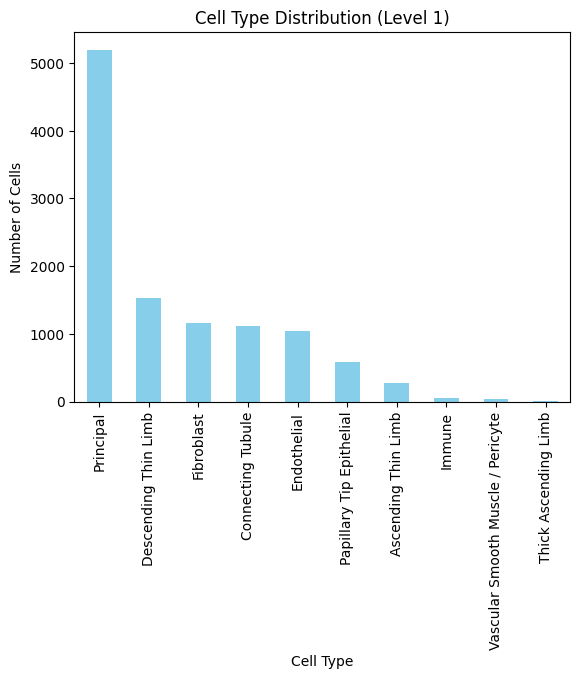

In [10]:
# Plot the distribution of cells per predicted cell type for l1
cell_type_counts_l1.plot(kind='bar', color='skyblue')
plt.title('Cell Type Distribution (Level 1)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

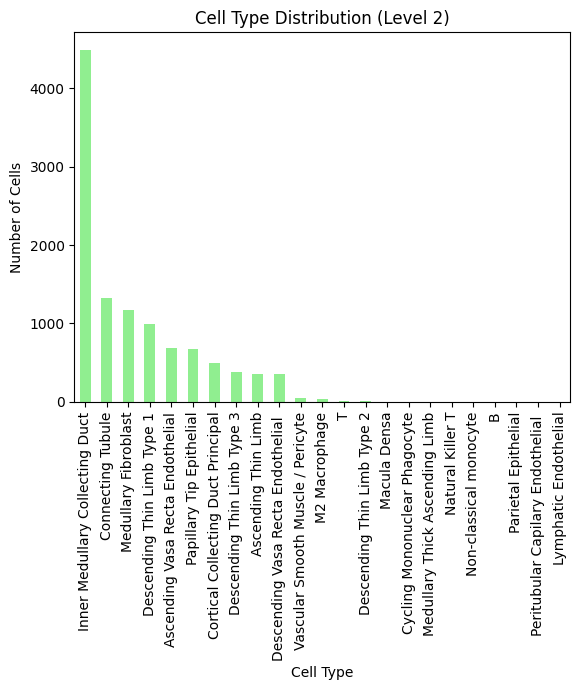

In [11]:
# Plot the distribution of cells per predicted cell type for l2
cell_type_counts_l2.plot(kind='bar', color='lightgreen')
plt.title('Cell Type Distribution (Level 2)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

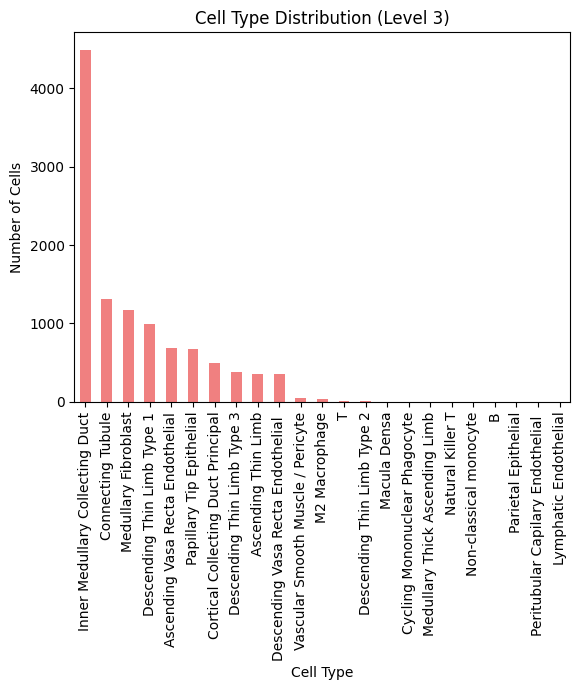

In [12]:
# Plot the distribution of cells per predicted cell type for l3
cell_type_counts_l3.plot(kind='bar', color='lightcoral')
plt.title('Cell Type Distribution (Level 3)')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Perform PCA to reduce the dimensionality of the data
sc.tl.pca(adata, svd_solver='arpack')

# Compute the neighbors graph using PCA (or other dimensionality reduction)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

/Users/venkateshtalasila/.virtualenvs/r-reticulate/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Compute UMAP embeddings
sc.tl.umap(adata)

### UMAP Visualization for Predicted Cell Types (Level 1)

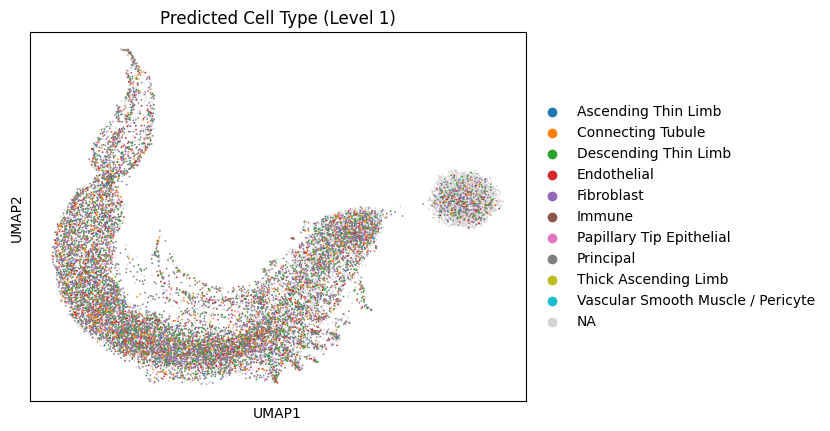

In [16]:
# UMAP for predicted cell type at level 1
sc.pl.umap(adata, color='predicted_l1', title='Predicted Cell Type (Level 1)', show=True)

The UMAP plot for **predicted cell types at Level 1** shows distinct clustering of cells based on their predicted identities:

- **Clear Clusters**: Cell types like **"Principal"**, **"Fibroblast"**, and **"Descending Thin Limb"** form tight, well-separated clusters, indicating clear gene expression differences between these types.
- **Less Abundant Cell Types**: **"Thick Ascending Limb"** and **"Vascular Smooth Muscle / Pericyte"** appear in smaller, more dispersed clusters, reflecting their lower abundance.
- **"NA" Category**: Cells that couldn't be assigned a predicted type appear as a scattered group, marked as "NA".
- **Biological Relevance**: The clustering aligns with the biological diversity of the kidney, with clear distinctions between epithelial, fibroblast, and immune cells.

This UMAP plot confirms that Azimuth effectively differentiates major kidney cell types based on RNA expression.

### UMAP Visualization for Predicted Cell Types (Level 2)

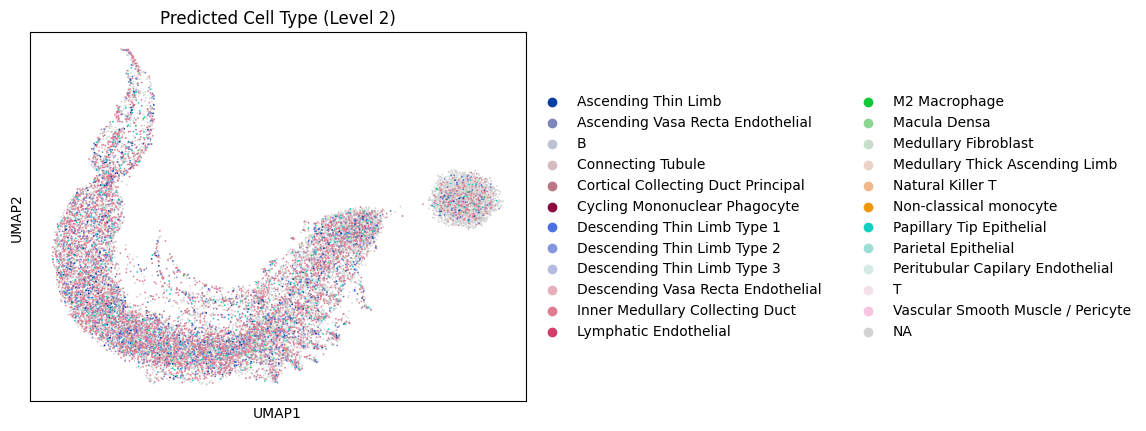

In [17]:
# UMAP for predicted cell type at level 2
sc.pl.umap(adata, color='predicted_l2', title='Predicted Cell Type (Level 2)', show=True)

The UMAP plot for **predicted cell types at Level 2** reveals more granular clusters compared to Level 1:

- **Distinct Clusters**: Key cell types such as **"Inner Medullary Collecting Duct"**, **"Medullary Fibroblast"**, and **"Papillary Tip Epithelial"** show well-separated clusters.
- **Smaller Subpopulations**: Cell types like **"Cycling Mononuclear Phagocyte"**, **"M2 Macrophage"**, and **"Macula Densa"** form smaller, dispersed clusters, indicating their lower abundance or specialized roles.
- **Diversity in Kidney Tissue**: The diversity of cell types in the kidney tissue is more apparent at this level, with multiple subtypes of previously identified categories (e.g., **"Descending Thin Limb"** and **"Vascular Smooth Muscle / Pericyte"**).
- **"NA" Category**: As with Level 1, there is a group of cells that are marked as "NA", which were not classified into any of the known cell types.

This UMAP plot highlights the heterogeneity of the kidney at a more detailed level, capturing subtle differences between various cell subtypes.

### UMAP Visualization for Predicted Cell Types (Level 3)

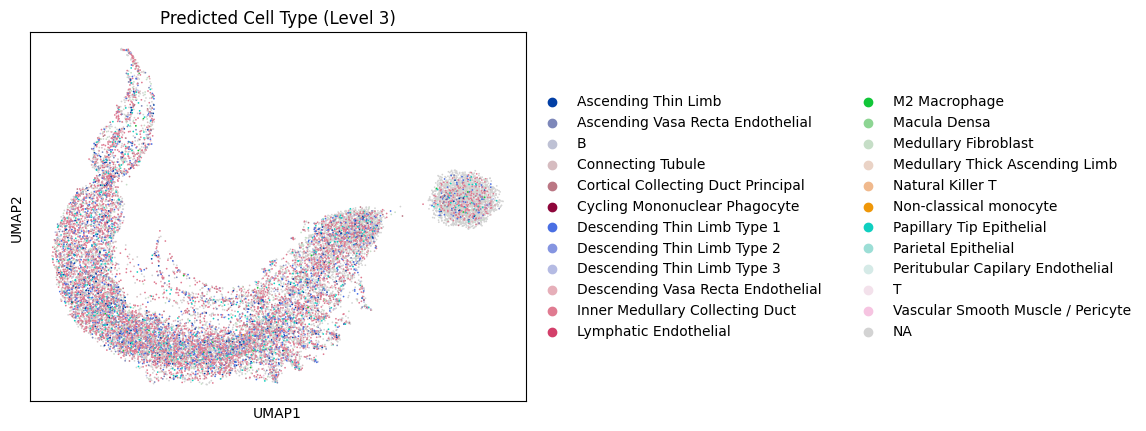

In [18]:
# UMAP for predicted cell type at level 3
sc.pl.umap(adata, color='predicted_l3', title='Predicted Cell Type (Level 3)', show=True)

The **UMAP plot for predicted cell types at Level 3** provides the most granular view of the data, offering insights into even more specific subtypes within kidney tissue. Here are some key observations:

- **Distinct Cell Types**: Similar to previous levels, major cell types such as **"Ascending Thin Limb"**, **"Connecting Tubule"**, and **"Inner Medullary Collecting Duct"** are clearly separated.
- **Subtypes are More Refined**: The clustering at Level 3 provides more detailed information about subsets within broader categories, such as various types of **"Descending Thin Limb"** and **"Medullary Fibroblast"**.
- **Smaller, Specific Clusters**: Some clusters, such as **"Cycling Mononuclear Phagocyte"**, **"Non-classical Monocyte"**, and **"Macula Densa"**, form smaller, more dispersed groupings, which could indicate their rarer presence in the dataset.
- **"NA" Category**: Again, we see an **"NA"** category, suggesting some cells have not been classified into any of the known categories at this level of prediction.

Overall, the Level 3 UMAP plot offers a deeper understanding of the tissue's cellular landscape, providing finer details and more resolution into cell type differentiation.

### Hierarchical Clustering of Cells

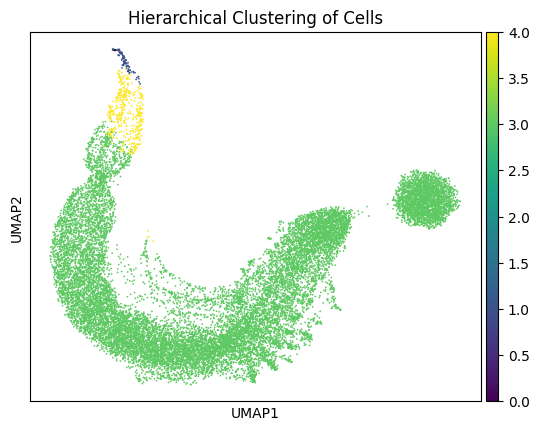

In [ ]:
# Apply hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=5)
adata.obs['cluster'] = clustering.fit_predict(adata.obsm['X_pca'])

# Plot the clustering results
sc.pl.umap(adata, color='cluster', title='Hierarchical Clustering of Cells', show=True)

The **UMAP plot for hierarchical clustering** shows the results of clustering cells into 5 distinct groups. Key observations from the plot:

- **Clear Clusters**: The UMAP visualization highlights how cells are grouped into five distinct clusters. These groups are represented by different colors, making it easier to observe the overall clustering pattern.
- **Cluster Distribution**: 
  - **Green Cluster**: The largest cluster, which forms the majority of the cells, is positioned in the central part of the plot.
  - **Blue and Yellow Clusters**: Smaller clusters appear on the periphery of the central group, with fewer cells in these regions, possibly representing more specialized or rare cell types.
- **Visualization**: The color bar to the right represents the cluster assignment for each cell, providing a clear and interpretable view of how hierarchical clustering has grouped the cells.

This clustering analysis provides a deeper view of how cells in the dataset might be related to each other based on their gene expression profiles.

### Distribution of Mapping Scores

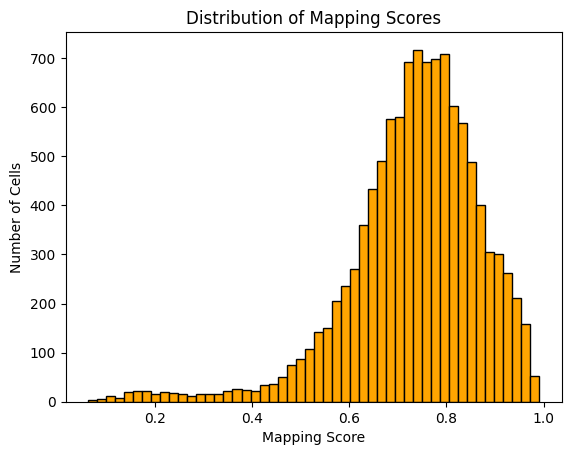

In [22]:
# Plot the distribution of mapping scores with borders around bins
adata.obs['mapping_score'].plot(kind='hist', color='orange', bins=50, edgecolor='black', title='Distribution of Mapping Scores')
plt.xlabel('Mapping Score')
plt.ylabel('Number of Cells')
plt.show()

The **histogram of mapping scores** displays the distribution of mapping scores across all cells in the dataset. Key observations:

- **Peak at Higher Scores**: The majority of cells have high mapping scores between 0.7 and 1.0, indicating that most cells have strong alignment to the reference dataset.
- **Long Tail on the Left**: A smaller number of cells have lower mapping scores, suggesting that these cells may be less well-matched to the reference or more difficult to annotate with confidence.
- **Shape of Distribution**: The distribution is right-skewed, with most cells clustering around the higher mapping scores.

The mapping score is a measure of how well each cell aligns with the reference, and this plot provides insights into the overall quality and confidence of the cell type predictions.